## Install and Import Dependencies

In [ ]:
!pip install gdown
!apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import cv2
import os
import random
import json
import pytesseract
import re
import editdistance
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Assignment Day 19

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Assignment Day 19


## Read the dataset

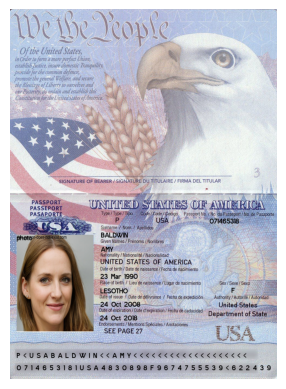

In [ ]:
# Check a random image
image_folder = '/content/drive/MyDrive/Assignment Day 19/passport data/passport data'
images = [cv2.imread(os.path.join(image_folder, file)) for file in os.listdir(image_folder)]

random_image = random.choice(images)

image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis(False)
plt.show()

In [ ]:
# Check ground truth folder
ground_truth_folder = '/content/drive/MyDrive/Assignment Day 19/Ground Truth/Ground Truth'
ground_truth = {}

for file in os.listdir(ground_truth_folder):
  with open(os.path.join(ground_truth_folder, file), 'r') as f:
    ground_truth[file] = json.load(f)

print(ground_truth)
print(f"\nNumber of JSON files: {len(ground_truth)}")

{'WILLIAMS_ROBERT.json': {'surname': 'WILLIAMS', 'given_name': 'ROBERT', 'nationality': 'UNITED STATES OF AMERICA', 'date_of_birth': '29 Oct 1982', 'place_of_birth': 'SVALBARD & JAN MAYEN ISLANDS', 'date_of_issue': '11 Dec 1999', 'date_of_expiration': '10 Dec 2009', 'sex': 'M'}, 'BALDWIN_AMY.json': {'surname': 'BALDWIN', 'given_name': 'AMY', 'nationality': 'UNITED STATES OF AMERICA', 'date_of_birth': '23 Mar 1990', 'place_of_birth': 'LESOTHO', 'date_of_issue': '24 Oct 2008', 'date_of_expiration': '24 Oct 2018', 'sex': 'F'}, 'VALDEZ_PHILIP.json': {'surname': 'VALDEZ', 'given_name': 'PHILIP', 'nationality': 'UNITED STATES OF AMERICA', 'date_of_birth': '14 Aug 1964', 'place_of_birth': 'SWITZERLAND', 'date_of_issue': '29 Jun 2008', 'date_of_expiration': '29 Jun 2018', 'sex': 'M'}, 'KAUFMAN_VALERIE.json': {'surname': 'KAUFMAN', 'given_name': 'VALERIE', 'nationality': 'UNITED STATES OF AMERICA', 'date_of_birth': '18 Sep 1973', 'place_of_birth': 'NIGERIA', 'date_of_issue': '15 Mar 2015', 'dat

## Preprocessing Images

Based on the image above, we can cut the top page and blur some unnecessary information that not related to the problem and save the images to a new folder.

In [ ]:
# Folder path
image_folder = '/content/drive/MyDrive/Assignment Day 19/passport data/passport data'
processed_folder = '/content/processed_passport_data'

# Create processed folder if it doesn't exist
os.makedirs(processed_folder, exist_ok=True)

# Process images
for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Could not read {img_name}, skipping...")
        continue

    # Convert to grayscale for better preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Assuming the passport has two halves, crop the bottom half (personal data page)
    height, width = gray.shape
    cropped = img[height // 2 :, :]  # Retain only the bottom half

    # Enhance image quality (increase contrast using histogram equalization)
    enhanced = cv2.convertScaleAbs(cropped, alpha=1.5, beta=20)

    # Blur the top and bottom edges slightly
    blur_mask = np.zeros_like(enhanced)
    blur_height = height // 12  # Define blur area height
    left_width = width // 3  # Define left blur width

    blur_mask[:blur_height, :] = 1  # Top blur mask
    blur_mask[-blur_height:, :] = 1  # Bottom blur mask
    blur_mask[:, :left_width] = 1  # Left blur mask

    blurred = cv2.GaussianBlur(enhanced, (31, 31), 0)
    enhanced[blur_mask == 1] = blurred[blur_mask == 1]

    # Save the processed image in RGB format
    processed_img = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
    output_path = os.path.join(processed_folder, img_name)
    cv2.imwrite(output_path, processed_img)

print("Image processing completed. Processed images saved in:", processed_folder)

Image processing completed. Processed images saved in: /content/processed_passport_data


In [ ]:
# Trying to extract an image
image = cv2.imread('/content/processed_passport_data/0.png')
extracted_text = pytesseract.image_to_string(image, lang='eng')
print(extracted_text)

ae : a" UF 1B

- - 7 — © ce
, ~

Surname / "Nom. Apellidos

WARNER -

Given Names / Prénoms / Nombres

AARON

Nationality / Nationalité / Nacionalidad

UNITED STATES OF AMERICA

Date of birth / Date de naissance / Fecha de nacimiento

  

  
 

 

   

24 Nov 1987
Place of birth / Lieu de naissance / Lugar de nacimiento Sex / Sexe / Sexo
SURINAME M :
Date of issue / Date de délivrance / Fecha de expedicion Authority / Autorité / Autoridad
-21 Oct 2006 - United States -
rat i ion / Fecha de a

Date’of expiration / Date d'expiration / Fecha de caducidad Department of State
20 Oct 2016
Endorsements / Mentions Spéciales / Anotaciones =

SEE PAGE 27 3

. ese eeaeeere see



It seems our image is not good enough when being extracted by Tesseract. Let's improve our image's quality and take the information of it.

## Improve the images

We try to convert the image to grayscale and enhance the contrast before being processed by Tesseract. After that, we can extract the necessary information and move them to their keys in .json file.

In [ ]:
# Read the image using OpenCV
image = cv2.imread('/content/processed_passport_data/0.png')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to enhance contrast
_, thresh_image = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)

# Use PIL to convert back to an Image object
processed_image = Image.fromarray(thresh_image)

# Extract text using Tesseract
extracted_text = pytesseract.image_to_string(processed_image, lang='eng')

# Fix common spelling errors
extracted_text = extracted_text.replace("Siirname", "Surname")  # Correct spelling error

# Parse the extracted text into JSON format
def parse_to_json(text):
    data = {}

    # Use regex to extract information
    data['surname'] = re.search(r"Surname[^\n]*\n([A-Z\s]+)", text)
    data['given_name'] = re.search(r"Given Names[^\n]*\n([A-Z\s]+)", text)
    data['nationality'] = re.search(r"Nationality[^\n]*\n([A-Z\s]+)", text)
    data['date_of_birth'] = re.search(r"Date of birth[^\n]*\n([\d\w\s]+)", text)
    data['place_of_birth'] = re.search(r"Place of birth[^\n]*\n([A-Z\s]+)", text)
    data['date_of_issue'] = re.search(r"Date of issue[^\n]*\n([\d\w\s]+)", text)
    data['date_of_expiration'] = re.search(r"Date of expiration[^\n]*\n([\d\w\s]+)", text)
    data['sex'] = re.search(r"Sex[^\n]*\n([A-Z\s]+)", text)

    # Extract results and strip whitespace, or set to an empty string if None
    for key, value in data.items():
        data[key] = value.group(1).strip() if value else ''

    # Remove newlines and unwanted characters
    for key, value in data.items():
        data[key] = value.replace("\n", " ").strip()

    return data

# Parse the extracted text into JSON
parsed_data = parse_to_json(extracted_text)

# Save as JSON
output_path = '/content/predictions.json'
with open(output_path, 'w') as f:
    json.dump(parsed_data, f, indent=4)

# Display the parsing result
print(extracted_text)
print(json.dumps(parsed_data, indent=4))
print(f"Extracted data saved to {output_path}")

Surname / Nom / Apeltides

WARNER

Given Names / Piénoms / Nombres

AARON

Nationality / Nationalité / Nacionalrdad

UNITED STATES OF AMERICA

Date of birth / Date de naissance / Fecha de nacimiento

24 Nov 1987

Place of birth / Lieu de naissance / Lugar de nacimiente

SURINAME

Date of issue / Date de délivrance / Fecha de expedicién

21 Oct 2006

Date of expiration / Date d'expiration / Fecha de caducidad

20 Oct 2016

Endorsements / Mentions Spéciales / Anotaciones

SEE PAGE 27

Sex / Sexe / Sexo.

M

Authority / Autovité / Autoridad
United States
Department of State

 

{
    "surname": "WARNER  G",
    "given_name": "AARON  N",
    "nationality": "UNITED STATES OF AMERICA  D",
    "date_of_birth": "24 Nov 1987  Place of birth",
    "place_of_birth": "SURINAME  D",
    "date_of_issue": "21 Oct 2006  Date of expiration",
    "date_of_expiration": "20 Oct 2016  Endorsements",
    "sex": "M  A"
}
Extracted data saved to /content/predictions.json


It seems better than before. But let's do the same thing to the entire images and calculate the evaluation matrics.

In [ ]:
# Function to parse extracted text into JSON format
def parse_to_json(text):
    data = {}

    # Use regex to extract information
    data['surname'] = re.search(r"Surname[^\n]*\n([A-Z\s]+)", text)
    data['given_name'] = re.search(r"Given Names[^\n]*\n([A-Z\s]+)", text)
    data['nationality'] = re.search(r"Nationality[^\n]*\n([A-Z\s]+)", text)
    data['date_of_birth'] = re.search(r"Date of birth[^\n]*\n([\d\w\s]+)", text)
    data['place_of_birth'] = re.search(r"Place of birth[^\n]*\n([A-Z\s]+)", text)
    data['date_of_issue'] = re.search(r"Date of issue[^\n]*\n([\d\w\s]+)", text)
    data['date_of_expiration'] = re.search(r"Date of expiration[^\n]*\n([\d\w\s]+)", text)
    data['sex'] = re.search(r"Sex[^\n]*\n([A-Z\s]+)", text)

    # Extract results and strip whitespace, or assign an empty string if None
    for key, value in data.items():
        data[key] = value.group(1).strip() if value else ''

    # Remove newline and unwanted characters
    for key, value in data.items():
        data[key] = value.replace("\n", " ").strip()

    return data

# Path to the image folder
input_folder = '/content/processed_passport_data'
output_folder = '/content/output_jsons'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Process each image in the folder
for image_filename in os.listdir(input_folder):
    image_path = os.path.join(input_folder, image_filename)

    # Check if the file is an image (e.g., with .png, .jpg, .jpeg extensions)
    if image_filename.endswith(('.png', '.jpg', '.jpeg')):
        # Read the image using OpenCV
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply thresholding to enhance contrast
        _, thresh_image = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)

        # Use PIL to convert it back into an Image object
        processed_image = Image.fromarray(thresh_image)

        # Extract text using Tesseract
        extracted_text = pytesseract.image_to_string(processed_image, lang='eng')

        # Correct common spelling mistakes
        extracted_text = extracted_text.replace("Siirname", "Surname")  # Correct spelling error
        extracted_text = extracted_text.replace("Piénoms", "Given Names")  # Correct spelling error

        # Parse the extracted text into JSON
        parsed_data = parse_to_json(extracted_text)

        # Retrieve surname and given_name for the output filename
        surname = parsed_data['surname']
        given_name = parsed_data['given_name']

        # Save the extraction results in JSON format with a name based on given_name and surname
        if surname and given_name:  # Ensure data exists for surname and given_name
            output_filename = f"{surname}_{given_name}_parsed.json"
        else:
            output_filename = os.path.splitext(image_filename)[0] + '_parsed.json'

        output_path = os.path.join(output_folder, output_filename)
        with open(output_path, 'w') as f:
            json.dump(parsed_data, f, indent=4)

        # Display parsing results
        print(f"Extraction results for {image_filename} saved at {output_path}")

Extraction results for 0.png saved at /content/output_jsons/WARNER  G_AARON  N_parsed.json
Extraction results for 2.png saved at /content/output_jsons/SMITH  G_JONATHAN  N_parsed.json
Extraction results for 18.png saved at /content/output_jsons/JUAREZ  G_EMILY  N_parsed.json
Extraction results for 14.png saved at /content/output_jsons/TAYLOR  G_TODD  N_parsed.json
Extraction results for 7.png saved at /content/output_jsons/KAUFMAN  G_VALERIE  N_parsed.json
Extraction results for 3.png saved at /content/output_jsons/MILLER  G_GILBERT  N_parsed.json
Extraction results for 19.png saved at /content/output_jsons/DALTON  G_TAMMY  N_parsed.json
Extraction results for 12.png saved at /content/output_jsons/WILLIAMS  G_ROBERT  N_parsed.json
Extraction results for 8.png saved at /content/output_jsons/DUARTE  G_WILLIAM  N_parsed.json
Extraction results for 17.png saved at /content/output_jsons/LOPEZ  G_JASON  N_parsed.json
Extraction results for 13.png saved at /content/output_jsons/RICHARDSON  G_

In [ ]:
# Function to calculate WER using edit distance
def wer(reference, hypothesis):
    reference = reference.split()
    hypothesis = hypothesis.split()

    # Initialize edit distance matrix
    dp = [[0] * (len(hypothesis) + 1) for _ in range(len(reference) + 1)]

    for i in range(len(reference) + 1):
        for j in range(len(hypothesis) + 1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            else:
                cost = 0 if reference[i - 1] == hypothesis[j - 1] else 1
                dp[i][j] = min(dp[i - 1][j - 1] + cost, dp[i][j - 1] + 1, dp[i - 1][j] + 1)

    return dp[len(reference)][len(hypothesis)] / float(len(reference)) if len(reference) > 0 else 0

# Function to calculate CER using edit distance
def cer(reference, hypothesis):
    reference = ''.join(reference.split())
    hypothesis = ''.join(hypothesis.split())

    # Initialize edit distance matrix
    dp = [[0] * (len(hypothesis) + 1) for _ in range(len(reference) + 1)]

    for i in range(len(reference) + 1):
        for j in range(len(hypothesis) + 1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            else:
                cost = 0 if reference[i - 1] == hypothesis[j - 1] else 1
                dp[i][j] = min(dp[i - 1][j - 1] + cost, dp[i][j - 1] + 1, dp[i - 1][j] + 1)

    return dp[len(reference)][len(hypothesis)] / float(len(reference)) if len(reference) > 0 else 0

# Path to the folders containing ground truth and extracted results
ground_truth_folder = '/content/drive/MyDrive/Assignment Day 19/Ground Truth/Ground Truth'
extracted_json_folder = '/content/output_jsons'

# Function to clean file names and match them
def clean_name(filename):
    # Remove prefixes like "G_" and suffixes like "N_parsed", then replace spaces with underscores
    filename = filename.replace('G_', '').replace(' N_parsed.json', '')
    # Replace multiple spaces with a single underscore
    filename = re.sub(r'\s+', '_', filename)
    # Remove unnecessary underscores at the end
    filename = filename.rstrip('_')
    return filename

# Comparison process
# Adjusted main function to match output files
correct_files = 0
total_files = 0
total_wer = 0
total_cer = 0

# Loop through each extracted result file
for extracted_filename in os.listdir(extracted_json_folder):
    if extracted_filename.endswith('_parsed.json'):
        # Clean the file name using clean_name
        cleaned_filename = clean_name(extracted_filename)

        # Ground truth file name follows the format LASTNAME_FIRSTNAME.json
        ground_truth_filename = f"{cleaned_filename}.json"
        extracted_file_path = os.path.join(extracted_json_folder, extracted_filename)
        ground_truth_file_path = os.path.join(ground_truth_folder, ground_truth_filename)

        # Check if the ground truth file exists
        if os.path.exists(ground_truth_file_path):
            # Read the extracted result file
            with open(extracted_file_path, 'r') as ef:
                extracted_data = json.load(ef)
                text = f"{extracted_data['given_name']} {extracted_data['surname']}"

            # Read the ground truth file
            with open(ground_truth_file_path, 'r') as gf:
                ground_truth_data = json.load(gf)
                ground_truth_text = f"{ground_truth_data['given_name']} {ground_truth_data['surname']}"

            # Calculate WER and CER
            wer_score = wer(ground_truth_text, text)
            cer_score = cer(ground_truth_text, text)

            total_wer += wer_score
            total_cer += cer_score

            print(f"File: {ground_truth_filename}")
            print(f"CER: {cer_score:.4f}")
            print(f"WER: {wer_score:.4f}")

            total_files += 1
            correct_files += 1
        else:
            print(f"Ground truth file not found for {cleaned_filename}")
    else:
        print(f"Invalid filename format: {extracted_filename}")

# Calculate average WER and CER
average_wer = total_wer / total_files if total_files > 0 else 0
average_cer = total_cer / total_files if total_files > 0 else 0

# Display the results
print("==========================")
print(f"Total files processed: {total_files}")
print(f"Correct files: {correct_files}")
print(f"Average CER: {average_cer:.4f}")
print(f"Average WER: {average_wer:.4f}")

File: ADAMS_PAUL.json
CER: 0.2222
WER: 1.0000
File: WILLIAMS_ROBERT.json
CER: 0.1429
WER: 1.0000
File: GONZALEZ_JENNIFER.json
CER: 0.1250
WER: 1.0000
File: ARMSTRONG_DANNY.json
CER: 0.1429
WER: 1.0000
File: HODGE_ROBERT.json
CER: 0.1818
WER: 1.0000
File: MILLER_GILBERT.json
CER: 0.1538
WER: 1.0000
File: TAYLOR_TODD.json
CER: 0.2000
WER: 1.0000
File: SMITH_JONATHAN.json
CER: 0.1538
WER: 1.0000
File: LOPEZ_JASON.json
CER: 0.2000
WER: 1.0000
File: GOODMAN_LYNN.json
CER: 0.1818
WER: 1.0000
File: KAUFMAN_VALERIE.json
CER: 0.1429
WER: 1.0000
File: DUARTE_WILLIAM.json
CER: 0.1538
WER: 1.0000
File: PARRISH_ASHLEY.json
CER: 0.1538
WER: 1.0000
File: WARNER_AARON.json
CER: 0.1818
WER: 1.0000
File: BALDWIN_AMY.json
CER: 0.2000
WER: 1.0000
File: VALDEZ_PHILIP.json
CER: 0.1667
WER: 1.0000
File: JUAREZ_EMILY.json
CER: 0.1818
WER: 1.0000
File: DALTON_TAMMY.json
CER: 0.1818
WER: 1.0000
File: RICHARDSON_WILLIAM.json
CER: 0.1176
WER: 1.0000
File: MORROW_JOSEPH.json
CER: 0.1667
WER: 1.0000
Total files pro

Based on the output, we have to adjust our regex function and clean our extraction text so that it will return the better result. Let's try to an image first after that we can apply it to the entire images.

## More Improvement

More improvement for cleaning and extracting the data.

In [ ]:
# Text cleaning
cleaned_text = re.sub(r"\n\s*\n", "\n", extracted_text.strip())  # Remove double blank lines
cleaned_text = re.sub(r"\s{2,}", " ", cleaned_text)  # Remove excessive whitespace

# Extract data using stricter regex
data = {
    "surname": re.search(r"Surname.*?\n([A-Z]+)\n", cleaned_text).group(1).strip(),
    "given_name": re.search(r"Given Names.*?\n([A-Z]+)\n", cleaned_text).group(1).strip(),
    "nationality": re.search(r"Nationality.*?\n([A-Z\s]+)\n", cleaned_text).group(1).strip(),
    "date_of_birth": re.search(r"Date of birth.*?\n([\d\w\s]+)\n", cleaned_text).group(1).strip(),
    "place_of_birth": re.search(r"Place of birth.*?\n([A-Z\s]+)\n", cleaned_text).group(1).strip(),
    "date_of_issue": re.search(r"Date of issue.*?\n([\d\w\s]+)\n", cleaned_text).group(1).strip(),
    "date_of_expiration": re.search(r"Date of expiration.*?\n([\d\w\s]+)\n", cleaned_text).group(1).strip(),
    "sex": re.search(r"Sex.*?\n([A-Z])\n", cleaned_text).group(1).strip(),
}

# Save the extracted results
with open("predictions.json", "w") as file:
    json.dump(data, file, indent=4)

# Print the results
print(json.dumps(data, indent=4))

{
    "surname": "MORROW",
    "given_name": "JOSEPH",
    "nationality": "UNITED STATES OF AMERICA",
    "date_of_birth": "28 Jul 1994",
    "place_of_birth": "IRAN",
    "date_of_issue": "04 Aug 20188",
    "date_of_expiration": "04 Aug 2023",
    "sex": "M"
}


It is really really better than before. We can see all the keys have their values correctly. Now, we can apply it to the entire images.

In [ ]:
# Function to parse extracted text into JSON format
def parse_to_json(text):
    # Clean up the text
    cleaned_text = re.sub(r"\n\s*\n", "\n", text.strip())  # Remove double blank lines
    cleaned_text = re.sub(r"\s{2,}", " ", cleaned_text)  # Remove excessive whitespace

    # Extract data using stricter regex patterns
    data = {
        "surname": re.search(r"Surname.*?\n([A-Z]+)\n", cleaned_text).group(1).strip() if re.search(r"Surname.*?\n([A-Z]+)\n", cleaned_text) else '',
        "given_name": re.search(r"Given Names.*?\n([A-Z]+)\n", cleaned_text).group(1).strip() if re.search(r"Given Names.*?\n([A-Z]+)\n", cleaned_text) else '',
        "nationality": re.search(r"Nationality.*?\n([A-Z\s]+)\n", cleaned_text).group(1).strip() if re.search(r"Nationality.*?\n([A-Z\s]+)\n", cleaned_text) else '',
        "date_of_birth": re.search(r"Date of birth.*?\n([\d\w\s]+)\n", cleaned_text).group(1).strip() if re.search(r"Date of birth.*?\n([\d\w\s]+)\n", cleaned_text) else '',
        "place_of_birth": re.search(r"Place of birth.*?\n([A-Z\s]+)\n", cleaned_text).group(1).strip() if re.search(r"Place of birth.*?\n([A-Z\s]+)\n", cleaned_text) else '',
        "date_of_issue": re.search(r"Date of issue.*?\n([\d\w\s]+)\n", cleaned_text).group(1).strip() if re.search(r"Date of issue.*?\n([\d\w\s]+)\n", cleaned_text) else '',
        "date_of_expiration": re.search(r"Date of expiration.*?\n([\d\w\s]+)\n", cleaned_text).group(1).strip() if re.search(r"Date of expiration.*?\n([\d\w\s]+)\n", cleaned_text) else '',
        "sex": re.search(r"Sex.*?\n([A-Z])\n", cleaned_text).group(1).strip() if re.search(r"Sex.*?\n([A-Z])\n", cleaned_text) else '',
    }

    # Remove unwanted characters or extra newlines
    for key, value in data.items():
        data[key] = value.replace("\n", " ").strip()

    return data

# Paths for input folder and output folder
input_folder = '/content/processed_passport_data'
output_folder = '/content/predictions_jsons'

# Create output folder if it doesn't already exist
os.makedirs(output_folder, exist_ok=True)

# Process each image in the input folder
for image_filename in os.listdir(input_folder):
    image_path = os.path.join(input_folder, image_filename)

    # Check if the file is an image (e.g., with extensions .png, .jpg, .jpeg)
    if image_filename.endswith(('.png', '.jpg', '.jpeg')):
        # Read the image using OpenCV
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply thresholding to improve contrast
        _, thresh_image = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)

        # Convert the processed image back to a PIL Image object
        processed_image = Image.fromarray(thresh_image)

        # Extract text using Tesseract OCR
        extracted_text = pytesseract.image_to_string(processed_image, lang='eng')

        # Fix common spelling errors
        extracted_text = extracted_text.replace("Siirname", "Surname")  # Correct spelling errors
        extracted_text = extracted_text.replace("Piénoms", "Given Names")  # Correct spelling errors

        # Parse the extracted text into JSON format
        parsed_data = parse_to_json(extracted_text)

        # Retrieve surname and given name for the output filename
        surname = parsed_data['surname']
        given_name = parsed_data['given_name']

        # Save the extracted results as a JSON file named based on the surname and given name
        if surname and given_name:  # Ensure there is data for both surname and given name
            output_filename = f"{surname}_{given_name}.json"
        else:
            output_filename = os.path.splitext(image_filename)[0] + '.json'

        output_path = os.path.join(output_folder, output_filename)
        with open(output_path, 'w') as f:
            json.dump(parsed_data, f, indent=4)

        # Display the parsing results
        print(f"Extraction results for {image_filename} saved at {output_path}")

Extraction results for 0.png saved at /content/predictions_jsons/WARNER_AARON.json
Extraction results for 2.png saved at /content/predictions_jsons/SMITH_JONATHAN.json
Extraction results for 18.png saved at /content/predictions_jsons/JUAREZ_EMILY.json
Extraction results for 14.png saved at /content/predictions_jsons/TAYLOR_TODD.json
Extraction results for 7.png saved at /content/predictions_jsons/KAUFMAN_VALERIE.json
Extraction results for 3.png saved at /content/predictions_jsons/MILLER_GILBERT.json
Extraction results for 19.png saved at /content/predictions_jsons/DALTON_TAMMY.json
Extraction results for 12.png saved at /content/predictions_jsons/WILLIAMS_ROBERT.json
Extraction results for 8.png saved at /content/predictions_jsons/DUARTE_WILLIAM.json
Extraction results for 17.png saved at /content/predictions_jsons/LOPEZ_JASON.json
Extraction results for 13.png saved at /content/predictions_jsons/RICHARDSON_WILLIAM.json
Extraction results for 4.png saved at /content/predictions_jsons/

After saving the result, we can move to the next step - Calculating the evaluation matrics, WER and CER, again.

In [ ]:
# Function to calculate CER (Character Error Rate)
def calculate_cer(prediction, ground_truth):
    prediction = prediction.replace(" ", "")  # Remove spaces
    ground_truth = ground_truth.replace(" ", "")  # Remove spaces
    distance = editdistance.eval(prediction, ground_truth)  # Edit distance calculation
    cer = distance / len(ground_truth) if len(ground_truth) > 0 else 0
    return cer

# Function to calculate WER (Word Error Rate)
def calculate_wer(prediction, ground_truth):
    prediction_words = prediction.split()  # Split prediction into words
    ground_truth_words = ground_truth.split()  # Split ground truth into words
    distance = editdistance.eval(prediction_words, ground_truth_words)  # Edit distance calculation
    wer = distance / len(ground_truth_words) if len(ground_truth_words) > 0 else 0
    return wer

# Paths for ground truth and extracted data folders
ground_truth_folder = '/content/drive/MyDrive/Assignment Day 19/Ground Truth/Ground Truth'
extracted_data_folder = '/content/predictions_jsons'

# Lists to store CER and WER values
cer_list = []
wer_list = []

# Loop through the extracted JSON files
for extracted_filename in os.listdir(extracted_data_folder):
    if extracted_filename.endswith('.json'):
        extracted_path = os.path.join(extracted_data_folder, extracted_filename)

        # Read extracted data
        with open(extracted_path, 'r') as f:
            extracted_data = json.load(f)
            extracted_text = " ".join([v for k, v in extracted_data.items()])  # Combine all values into a string

        # Corresponding ground truth file path
        ground_truth_path = os.path.join(ground_truth_folder, extracted_filename)

        # Check if ground truth exists
        if os.path.exists(ground_truth_path):
            with open(ground_truth_path, 'r') as f:
                ground_truth_data = json.load(f)
                ground_truth_text = " ".join([v for k, v in ground_truth_data.items()])  # Combine all values into a string

            # Calculate CER and WER
            cer = calculate_cer(extracted_text, ground_truth_text)
            wer = calculate_wer(extracted_text, ground_truth_text)

            cer_list.append(cer)
            wer_list.append(wer)

            # Print file-specific CER and WER
            print(f"File: {extracted_filename}")
            print(f"CER: {cer:.4f}")
            print(f"WER: {wer:.4f}")
        else:
            print(f"Ground truth for {extracted_filename} not found.")

# Calculate and print average CER and WER
average_cer = sum(cer_list) / len(cer_list) if cer_list else 0
average_wer = sum(wer_list) / len(wer_list) if wer_list else 0

print("\n==========================")
print(f"Average CER: {average_cer:.4f}")
print(f"Average WER: {average_wer:.4f}")

File: PARRISH_ASHLEY.json
CER: 0.1493
WER: 0.2353
File: JUAREZ_EMILY.json
CER: 0.0152
WER: 0.0588
File: ARMSTRONG_DANNY.json
CER: 0.0143
WER: 0.0588
File: HODGE_ROBERT.json
CER: 0.0000
WER: 0.0000
File: GOODMAN_LYNN.json
CER: 0.0000
WER: 0.0000
File: WILLIAMS_ROBERT.json
CER: 0.4943
WER: 0.5714
File: KAUFMAN_VALERIE.json
CER: 0.0143
WER: 0.0588
File: LOPEZ_JASON.json
CER: 0.0000
WER: 0.0000
File: MORROW_JOSEPH.json
CER: 0.0308
WER: 0.0588
File: SMITH_JONATHAN.json
CER: 0.0580
WER: 0.1176
File: RICHARDSON_WILLIAM.json
CER: 0.0000
WER: 0.0000
File: VALDEZ_PHILIP.json
CER: 0.0000
WER: 0.0000
File: BALDWIN_AMY.json
CER: 0.0000
WER: 0.0000
File: MILLER_GILBERT.json
CER: 0.2874
WER: 0.2381
File: GONZALEZ_JENNIFER.json
CER: 0.0845
WER: 0.1765
File: TAYLOR_TODD.json
CER: 0.0000
WER: 0.0000
File: DUARTE_WILLIAM.json
CER: 0.0000
WER: 0.0000
File: DALTON_TAMMY.json
CER: 0.0000
WER: 0.0000
File: WARNER_AARON.json
CER: 0.0000
WER: 0.0000
File: ADAMS_PAUL.json
CER: 0.0000
WER: 0.0000

Average CER: 0

Based on the output, there is a significant decrease of those evaluation matrics. Before, we got `CER : 0.1676` and `WER : 1.000`. Now, we get the better result - `CER : 0.0574` and `WER : 0.0787`. The lower the CER or WER we get, the better the result we achieve. Even thought, there is data named `WILLIAMS_ROBERT.json` has bad result.